

### Goals 

Preliminary workflow for detecting FG dwar dippers: 
- Query ~10,000 or so unique FG dwards
- Determine cuts for ideal study
- Develop a preliminary light curve query conditions


In [1]:
print (True)

True


In [2]:
from tqdm import tqdm

In [3]:
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=True, num_workers=8)

2023-12-05 13:32:06,278	INFO worker.py:1673 -- Started a local Ray instance.


In [4]:
## Current issue: I must load all columns to use `by_each`... not sure where is the missmatch between columns?

#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/projects3/ivoa_demo/gaia/catalog")

ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

#sources load takes a minute, since it creates a healpix alignment on load
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

In [5]:
xm_table = gaia.cone_search(ra=63, dec=35, radius=7).crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 100 and nobs_r_ztf_dr14 > 100 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

In [6]:
%%time
xm_table = xm_table.compute() # compute catalog level table

(dask:cone_filter-1db2fc91-c4a8-49ce-ac8c-e1ddb7b5243d pid=51275) /astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
(dask:cone_filter-1db2fc91-c4a8-49ce-ac8c-e1ddb7b5243d pid=51275)   data_frame["_CONE_SEP"] = df_separations


CPU times: user 3.76 s, sys: 687 ms, total: 4.45 s
Wall time: 17.8 s


In [7]:
print (f"Number of unique objects: {len(xm_table.index.unique())}")

Number of unique objects: 22238


In [8]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """
    npix = hp.nside2npix(nside)
    
    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map


In [9]:
Sky = SkyCoord(ra=xm_table.ra_gaia.values*u.deg, 
              dec=xm_table.dec_gaia.values*u.deg)

In [10]:
# convert coordinates to Galactic frame (l,b)
sky_gal = Sky.galactic

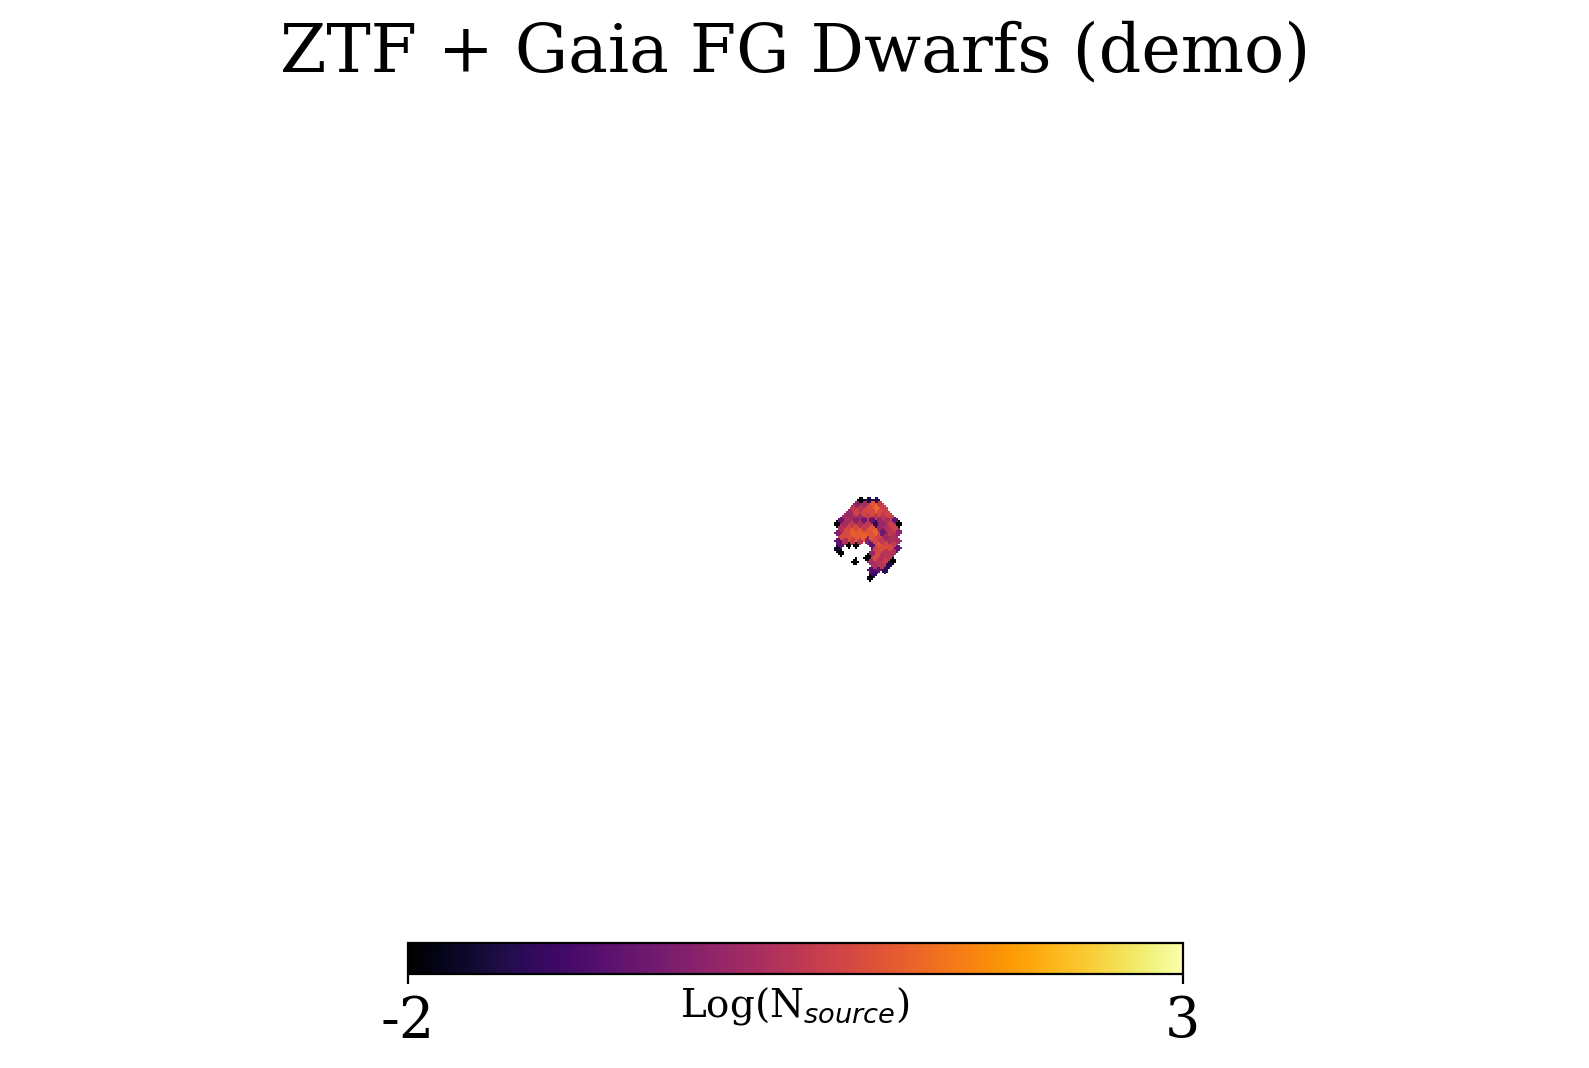

In [11]:
# Create Healpy projection 
hpx_map = cat2hpx(sky_gal.l.value-180,
                  sky_gal.b.value, 
                  nside=50, radec=False)

plt.figure(figsize=(10,10))
plt.grid(True, color='k', lw=22)
hp.mollview(np.log(hpx_map), cmap='inferno', hold=True,min=-2, max=3,
                   flip='astro', remove_dip=False,
                   remove_mono=True, 
                  title='ZTF + Gaia FG Dwarfs (demo)', 
           unit='Log(N$_{source}$)')

In [12]:
# hipscat xm_table
table_hips = lsdb.from_dataframe(
    xm_table, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1e10
)

# load lazy
source_tbl_final = table_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
)

In [13]:
%%time
# compute source table
_src = source_tbl_final.compute()

CPU times: user 1min 7s, sys: 40.2 s, total: 1min 47s
Wall time: 8min 10s


In [14]:
def fetch_lc(hips_id, table=_src, band='r'):
    """This function fetches the light curve for a given hips_id and band.
    
    Parameters
    ----------
    hips_id : int
    band (str): photometric band (default='r')

    Returns
    -------
    light curve table for a given band 
    """
    one_object = table.query(f"_hipscat_index == {hips_id}")

    if band=='r':
        one_object_rband = one_object.query("band == \"r\"")
        cat = one_object_rband['catflags'] != -32768 
        # argsort by times 
        x, y, z = one_object_rband["mjd"][cat], one_object_rband["mag"][cat], one_object_rband["magerr"][cat]
        xs = np.argsort(x.values)
        return x.values[xs], y.values[xs], z.values[xs]
    
    elif band=='g':
        one_object_gband = one_object.query("band == \"g\"")
        cat = one_object_gband['catflags'] != -32768 
        x, y, z = one_object_gband["mjd"][cat], one_object_gband["mag"][cat], one_object_gband["magerr"][cat]
        xs = np.argsort(x.values)
        return x.values[xs], y.values[xs], z.values[xs]

    elif band=='i':
        one_object_iband = one_object.query("band == \"i\"")
        x, y, z = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]
        xs = np.argsort(x.values)
        return x.values[xs], y.values[xs], z.values[xs]

    elif band=='all':
        one_object_rband = one_object.query("band == \"r\"")
        one_object_gband = one_object.query("band == \"g\"")
        one_object_iband = one_object.query("band == \"i\"")

        gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
        rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
        iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]


        return gband_mjd, gband_mag, gband_magerr, rband_mjd, rband_mag, rband_magerr, iband_mjd, iband_mag, iband_magerr

CPU times: user 3.03 s, sys: 5.36 s, total: 8.38 s
Wall time: 7.8 s


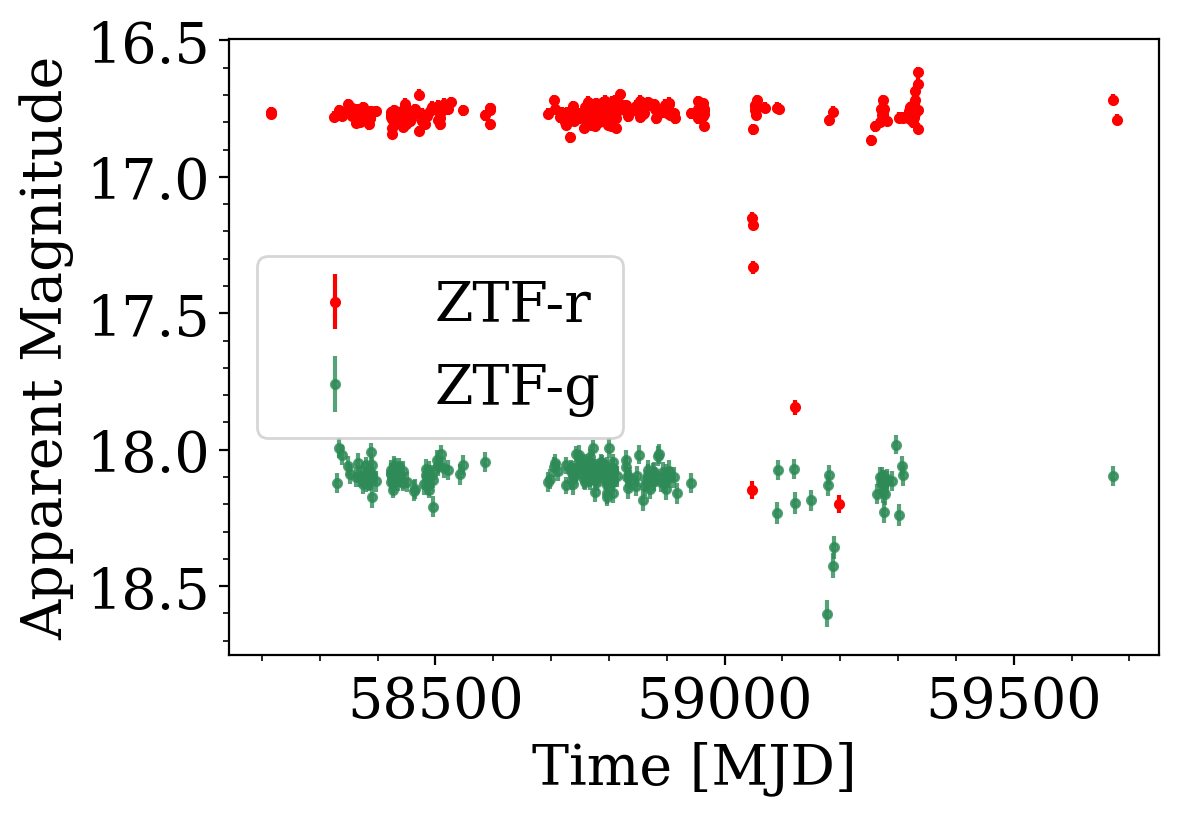

In [24]:
%%time

# let's plot a single light curve as a proof of concept
rnd = _src.index.unique()[3]
lc_r = fetch_lc(rnd, band='r')
lc_g = fetch_lc(rnd, band='g')

plt.figure(figsize=(6, 4))
plt.errorbar(lc_r[0], lc_r[1], yerr=lc_r[2], fmt='.', color='r', label='ZTF-r')
plt.errorbar(*lc_g, fmt='.', color='seagreen', alpha=0.8, label='ZTF-g')
plt.ylabel("Apparent Magnitude")
plt.xlabel("Time [MJD]")
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])
plt.legend()

## Computed Statistics for Analysis

In [25]:
import astropy.stats as astro_stats

In [26]:
def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)


def frac_above_dev(dev):
    """Calculate the fraction of detections above 2 sigma from the deviation"""
    M = np.median(dev)
    # fraction above 2-sigma from the M
    two_sig = M + 2*np.std(dev)
    
    return len(dev[dev>two_sig])/len(dev)


def assymetry_yso_M(mag):
    """Calculate the magnitude assymetry score defined by Hillenbrand et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8/pdf).

    Described in the paper: 
    Objects that have M values <0 are predominately brightening,
    objects with M values >0 are predominantly dimming, and
    objects with M values near 0 have symmetric light curves.

    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    
    Returns:
    --------
    assymetry (float): Assymetry score.
    """
    mag_decile = np.percentile(mag, 10)

    return (mag_decile - np.nanmedian(mag))/np.nanstd(mag)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


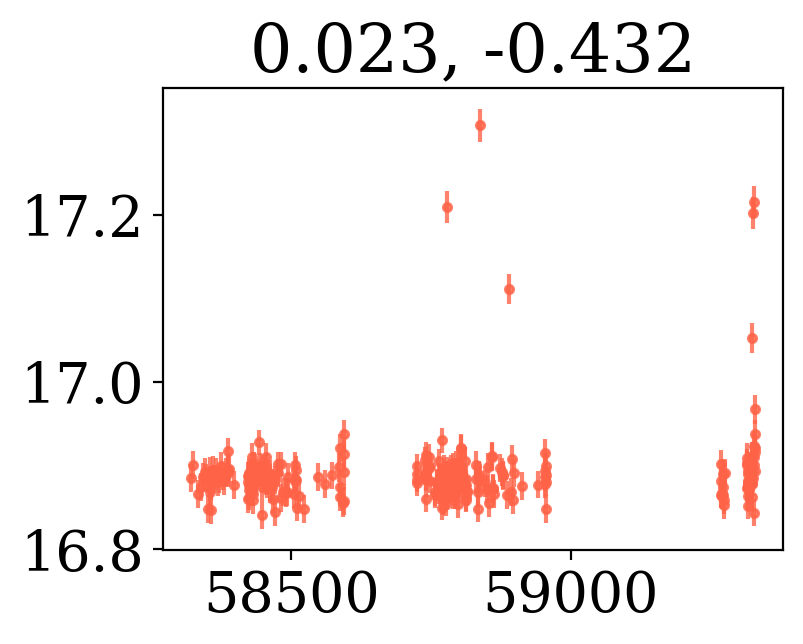

In [137]:
# write a simple for loop
demo_ids = _src.index.unique()[0:50].values
for _id in tqdm(demo_ids):
    rnd = _id
    lc_r = fetch_lc(rnd, band='r')
    
    dev_dat = deviation(lc_r[1], lc_r[2])
    frac_dev = frac_above_dev(dev_dat)
    M_var = assymetry_yso_M(lc_r[1])
        
    if frac_dev>0.02 and M_var>-0.5:
        plt.figure(figsize=(4, 3))
        plt.errorbar(*lc_r, fmt='.', alpha=0.8, color='tomato')
        plt.title(f"{np.round(frac_dev, 3)}, {np.round(M_var, 3)}")



In [18]:
# let's do this with with the .for_each workflow

In [47]:
def custom_function(df):
    df_rband = df.query("band == \"r\"")
    cat = df_rband['catflags'] != -32768 # remove spurious measurements
    x, y, yerr = df_rband["mjd"][cat], df_rband["mag"][cat], df_rband["magerr"][cat]
    x, y, yerr  = x.values, y.values, yerr.values
    xs = np.argsort(x)
    x, y, yerr = x[xs], y[xs], yerr[xs]

    frac_dev = frac_above_dev(deviation(y, yerr))
    M_var = asymmetry_yso_M(y)

    if isinstance(frac_dev, float) and isinstance(M_var, float):
        return pd.DataFrame(
        {
            "ps1_objid" : [df["ps1_objid"].values.tolist()[0]],
            "frac_dev": [frac_above_dev(deviation(y, yerr))],
            "M_var": [assymetry_yso_M(y)]
        }
    )
    else:
        return pd.DataFrame({"ps1_objid":[], "frac_dev":[], "M_var":[]})

In [28]:
%%time
ztf_sample_with_sources_rehips = lsdb.from_dataframe(
    _src, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia",
    threshold=1e9
)

CPU times: user 44.5 s, sys: 1min 19s, total: 2min 3s
Wall time: 1min 58s


In [48]:
%%time
# compute custom function for each light curve
var_analysis = ztf_sample_with_sources_rehips.for_each(
    key="ps1_objid",                       # groupby index
    ufunc=custom_function, # apply(ufunc) for each group
    meta={"ps1_objid": "i8", 
          "frac_dev": "f8", 
          "M_var": "f8"}                       # return metadata
).compute()

2023-12-05 15:12:11,177	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 33)() (pid=51278, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/optimization.py", line 992, in __call__
    return core.get(self.dsk, self.outkey, dict(zip(self.inkeys, args)))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/core.py", line 157, in get
    result = _execute_task(task, cache)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/core.py", line 127, in _execute_task
    return func(*(_execute_task(a, cache) for a in args))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/l

2023-12-05 15:12:11,184	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 32)() (pid=51281, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/optimization.py", line 992, in __call__
    return core.get(self.dsk, self.outkey, dict(zip(self.inkeys, args)))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/core.py", line 157, in get
    result = _execute_task(task, cache)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/core.py", line 127, in _execute_task
    return func(*(_execute_task(a, cache) for a in args))
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/l

2023-12-05 15:12:12,178	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 25)() (pid=51281, ip=128.95.0.72)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::dask:apply-f17eb92c-07e1-4917-ba57-2ef2b68da55c() (pid=51281, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/utils.py", line 1110, in __call__
    return getattr(__obj, self.method)(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1353, in apply
    result = self._python_apply_general(f, self._selected_obj)
  File "/epyc/users/atzanida/anaconda3/e

2023-12-05 15:12:14,203	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 19)() (pid=51278, ip=128.95.0.72)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::dask:apply-3cc09494-891c-4eb5-a517-6201f857b077() (pid=51278, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/utils.py", line 1110, in __call__
    return getattr(__obj, self.method)(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1353, in apply
    result = self._python_apply_general(f, self._selected_obj)
  File "/epyc/users/atzanida/anaconda3/e

RayTaskError(NameError): [36mray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 0)()[39m (pid=51278, ip=128.95.0.72)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: [36mray::dask:apply-6c7e8a5c-1782-4f9e-b1a6-447b091fbeb3()[39m (pid=51278, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/utils.py", line 1110, in __call__
    return getattr(__obj, self.method)(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1353, in apply
    result = self._python_apply_general(f, self._selected_obj)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1402, in _python_apply_general
    values, mutated = self.grouper.apply(f, data, self.axis)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/ops.py", line 767, in apply
    res = f(group)
  File "/tmp/ipykernel_50648/2434367184.py", line 10, in custom_function
NameError: name 'asymmetry_yso_M' is not defined

2023-12-05 15:12:23,199	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 9)() (pid=51276, ip=128.95.0.72)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::dask:apply-68499a64-4461-4d2c-80bd-e1ab3953c899() (pid=51276, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/utils.py", line 1110, in __call__
    return getattr(__obj, self.method)(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1353, in apply
    result = self._python_apply_general(f, self._selected_obj)
  File "/epyc/users/atzanida/anaconda3/en

2023-12-05 15:12:24,207	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::dask:('from-delayed-7be2df32cab6cb327ccd0135bc770669', 28)() (pid=51275, ip=128.95.0.72)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.RayTaskError: ray::dask:apply-e35a551e-94d4-4f7e-97aa-6276cce76fdd() (pid=51275, ip=128.95.0.72)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/ray/util/dask/scheduler.py", line 432, in dask_task_wrapper
    result = func(*actual_args)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/utils.py", line 1110, in __call__
    return getattr(__obj, self.method)(*args, **kwargs)
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1353, in apply
    result = self._python_apply_general(f, self._selected_obj)
  File "/epyc/users/atzanida/anaconda3/e

## Final Reccomendation List of Conditions